Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [2]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
import talib, math
%matplotlib inline

In [20]:
def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1600]
    return feature


def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def change_undefined(x):
    undefined_value = -1
    if x == 'NaN':
        return undefined_value
    if math.isnan(x):
        return undefined_value
    if math.isinf(x):
        return undefined_value
    if x < -1:
        return undefined_value
    return x

for_ml = get_for_learn_clean_df(pd.read_csv('predict_7_facies_experiment_start_interval_1.csv', sep=','))
for name_feature in for_ml.columns:
    if(name_feature != 'wellName' and name_feature != 'Facies' and name_feature != 'LAYER'):
        for_ml[name_feature] = for_ml[name_feature].apply(change_undefined)

display(for_ml.describe())
display(for_ml)
wells_samples_df = get_well_dfs(for_ml)
global_name_predict_model = 'random'

AGR           ANK           ASP            BK            GR  \
count  65203.000000  65203.000000  65203.000000  6.520300e+04  65203.000000   
mean       0.360946      0.795635      0.259987  1.161775e+02     11.011421   
std        0.255463      0.197327      0.287134  2.507225e+04      8.603413   
min        0.000000      0.000000      0.000000  0.000000e+00      1.136300   
25%        0.143396      0.711833      0.041554  6.099850e+00      7.527500   
50%        0.336373      0.835980      0.139414  7.500000e+00      9.540000   
75%        0.560907      0.945435      0.382225  9.640000e+00     12.260000   
max        1.000000      1.000000      1.000000  6.402033e+06    113.800000   

                LIT            MD          NKTB            SP  \
count  65203.000000  65203.000000  65203.000000  65203.000000   
mean       1.854133   2429.575563      3.969521     92.619318   
std        1.408364    244.506154      1.800932     32.629677   
min        1.000000   2005.800000      0.620000      6.477356   
25%        1.000000   2223.000000      2.804500     71.665000   
50%        1.000000   2440.400000      3.900000     95.577630   
75%        4.000000   2612.200000      4.830000    112.186850   
max        6.000000   3169.600000     23.520000    222.862200   

       catBoost_prod_39  catBoost_prod_52  catBoost_prod_152  \
count      65203.000000      65203.000000       65203.000000   
mean           3.003313          3.003374           3.003313   
std            0.115066          0.116126           0.115066   
min            3.000000          3.000000           3.000000   
25%            3.000000          3.000000           3.000000   
50%            3.000000          3.000000           3.000000   
75%            3.000000          3.000000           3.000000   
max            7.000000          7.000000           7.000000   

       catBoost_prod_100        random  KNeighborsClassifier_1  \
count       65203.000000  65203.000000            65203.000000   
mean            3.003313      3.000675                3.005276   
std             0.115066      0.051950                0.145175   
min             3.000000      3.000000                3.000000   
25%             3.000000      3.000000                3.000000   
50%             3.000000      3.000000                3.000000   
75%             3.000000      3.000000                3.000000   
max             7.000000      7.000000                7.000000   

       KNeighborsClassifier_1_log      catBoost           all  
count                65203.000000  65203.000000  65203.000000  
mean                     3.004478      3.003190      3.000613  
std                      0.133767      0.112917      0.049533  
min                      3.000000      3.000000      3.000000  
25%                      3.000000      3.000000      3.000000  
50%                      3.000000      3.000000      3.000000  
75%                      3.000000      3.000000      3.000000  
max                      7.000000      7.000000      7.000000

AGR       ANK       ASP      BK     GR  LAYER  LIT      MD  NKTB  \
0      0.000000  1.000000  0.022904   24.38  14.44   Bazh  1.0  2680.4  2.04   
1      0.000000  1.000000  0.030532   30.97  15.87   Bazh  1.0  2680.6  1.92   
2      0.000000  1.000000  0.028539   60.19  17.99   Bazh  1.0  2680.8  1.92   
3      0.000000  1.000000  0.024561  201.56  18.16   Bazh  1.0  2681.0  1.90   
4      0.000000  1.000000  0.033411  250.89  19.29   Bazh  1.0  2681.2  1.81   
...         ...       ...       ...     ...    ...    ...  ...     ...   ...   
65198  0.125445  0.817894  0.056335    8.00   8.24  UV1_2  1.0  2796.2  2.19   
65199  0.071644  0.846284  0.049705    8.60   8.51  UV1_3  1.0  2796.4  2.14   
65200  0.000000  0.766791  0.043075    8.80   8.98  UV1_3  1.0  2796.6  2.28   
65201  0.067658  0.664587  0.036444    9.10   8.53  UV1_3  1.0  2796.8  2.46   
65202  0.286850  0.636196  0.005946    9.00   7.43  UV1_3  1.0  2797.0  2.51   

             SP  wellName  catBoost_prod_39  catBoost_prod_52  \
0      106.8393  spk1205L                 3                 3   
1      106.3398  spk1205L                 3                 3   
2      106.4703  spk1205L                 3                 3   
3      106.7308  spk1205L                 3                 3   
4      106.1513  spk1205L                 3                 3   
...         ...       ...               ...               ...   
65198   94.6000   spk963L                 3                 3   
65199   95.1000   spk963L                 3                 3   
65200   95.6000   spk963L                 3                 3   
65201   96.1000   spk963L                 3                 3   
65202   98.4000   spk963L                 3                 3   

       catBoost_prod_152  catBoost_prod_100  random  KNeighborsClassifier_1  \
0                      3                  3       3                       3   
1                      3                  3       3                       3   
2                      3                  3       3                       3   
3                      3                  3       3                       3   
4                      3                  3       3                       3   
...                  ...                ...     ...                     ...   
65198                  3                  3       3                       3   
65199                  3                  3       3                       3   
65200                  3                  3       3                       3   
65201                  3                  3       3                       3   
65202                  3                  3       3                       3   

       KNeighborsClassifier_1_log  catBoost  all  
0                               3         3    3  
1                               3         3    3  
2                               3         3    3  
3                               3         3    3  
4                               3         3    3  
...                           ...       ...  ...  
65198                           3         3    3  
65199                           3         3    3  
65200                           3         3    3  
65201                           3         3    3  
65202                           3         3    3  

[65203 rows x 20 columns]

['spk1205L' 'spk146R' 'spk1508' 'spk1528' 'spk1700' 'spk1701' 'spk1703'
 'spk1707' 'spk1710' 'spk1718' 'spk1725' 'spk1740' 'spk1741' 'spk1742'
 'spk1745L' 'spk1753' 'spk1755' 'spk1764' 'spk1765' 'spk1779' 'spk1791'
 'spk1792' 'spk1793' 'spk1794' 'spk1796' 'spk1805' 'spk214P' 'spk236'
 'spk401' 'spk404' 'spk408' 'spk421R' 'spk422R' 'spk437' 'spk467'
 'spk564P' 'spk632' 'spk804' 'spk805' 'spk808' 'spk833R' 'spk870PL'
 'spk872PL' 'spk902' 'spk904' 'spk908' 'spk914' 'spk924L' 'spk941'
 'spk963L']


In [ ]:
#Вuзуализируем скважины

['spk1528']


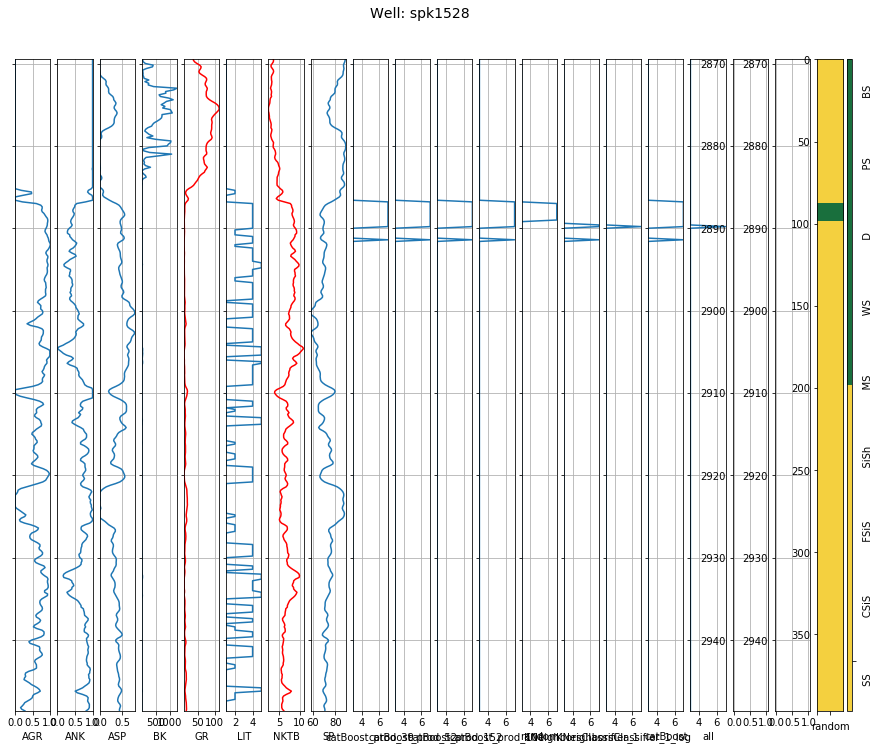

In [21]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def get_wells_with_7_facies(wells_all):
    wells_7_namens = wells_all[wells_all[global_name_predict_model] == 7]['wellName'].unique()
    print(wells_7_namens)
    wells = []
    for name in wells_7_namens:
        well = wells_all[wells_all['wellName'] == name]
        wells.append(well)
    return wells

def make_facies_log_plot(logs):
    facies_colors = ['#F4D03F', '#196F3D']
    mpl.rcParams['figure.figsize'] = (20.0, 10.0)


    logs = logs.sort_values(by='MD')
    cmap_facies = colors.ListedColormap(
        facies_colors[0:len(facies_colors)], 'indexed')

    cluster = np.repeat(np.expand_dims(logs[global_name_predict_model].values, 1), 100, 1)

    features_names = logs.columns
    count_for_view = len(features_names)
    f, ax = plt.subplots(nrows=1, ncols=count_for_view, figsize=(15, 12))
    number_feature = 0
    for feature_name in features_names:
        if feature_name not in ['wellName', 'LAYER', 'MD']:
            if feature_name in ['GR', 'NKTB', 'BBANDS']:
                ax[number_feature].plot(logs[feature_name], logs.MD, 'r')
            else:
                ax[number_feature].plot(logs[feature_name], logs.MD, '-')
            number_feature += 1

    facies_index = count_for_view - 1
    im = ax[facies_index].imshow(cluster, interpolation='none', aspect='auto',
                                 cmap=cmap_facies, vmin=-1, vmax=12)
    divider = make_axes_locatable(ax[facies_index])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label((17 * ' ').join([' SS ', 'CSiS', 'FSiS',
                                    'SiSh', ' MS ', ' WS ', ' D  ',
                                    ' PS ', ' BS ']))
    cbar.set_ticks(range(0, 1))
    cbar.set_ticklabels('')


    for i in range(len(ax) - 1):
        ax[i].set_ylim(logs.MD.min(), logs.MD.max())
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    number_feature = 0
    for feature_name in features_names:
        if feature_name not in ['wellName', 'LAYER', 'MD']:
            ax[number_feature].set_xlabel(feature_name)
            ax[number_feature].set_xlim(logs[feature_name].min(), logs[feature_name].max())
            ax[number_feature].set_yticklabels([])
            number_feature += 1

    ax[facies_index].set_xlabel(global_name_predict_model)
    ax[facies_index].set_xticklabels([])
    f.suptitle('Well: %s' % logs.iloc[0]['wellName'], fontsize=14, y=0.94)

def add_features(well_in):
    well = well_in.copy()
    upper, middle, lower = talib.BBANDS(well['GR'],
                                        timeperiod=5,
                                        matype=talib.MA_Type.EMA)
    well['BBANDS'] = upper - lower
    well['TRIX'] = talib.TRIX(well['GR'], timeperiod=5)
    well['F'] = well['GR'] - well['GR'].shift(1)
    return well
    
    
def view_facies(wells_7_dfs):
    for well in wells_7_dfs:
        make_facies_log_plot(well)
        # if not well[well['wellName'] == 'spk429L'].empty:
        #     well__ = well[well['MD'] > 2520]
        #     well_ = add_features(well__[well__['MD'] < 2580])
        #     make_facies_log_plot(well_)
        


wells_7_dfs = get_wells_with_7_facies(for_ml)
view_facies(wells_7_dfs)

['spk1519' 'spk1521' 'spk1527' 'spk1749PL' 'spk400' 'spk424R' 'spk429L']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: UserWarning: Attempting to set identical left == right == -1.0 results in singular transformations; automatically expanding.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:70: UserWarning: Attempting to set identical left == right == -1.0 results in singular transformations; automatically expanding.


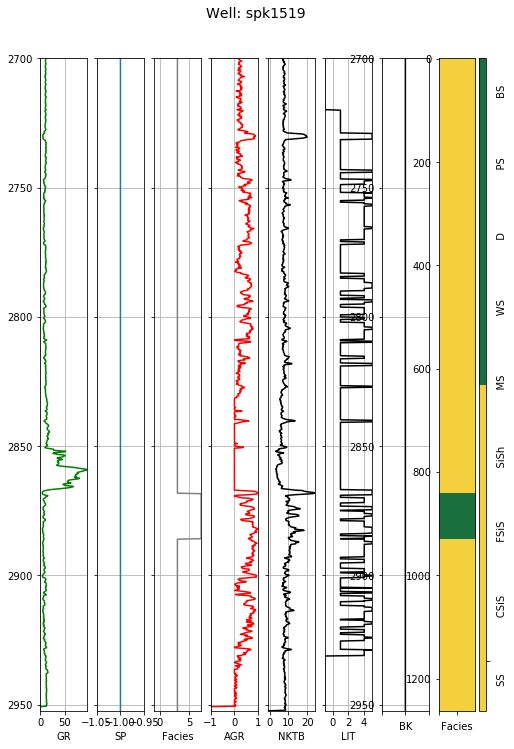

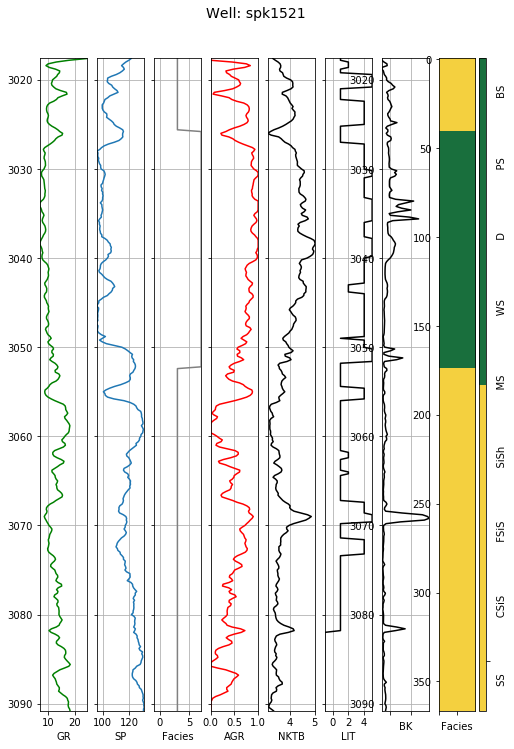

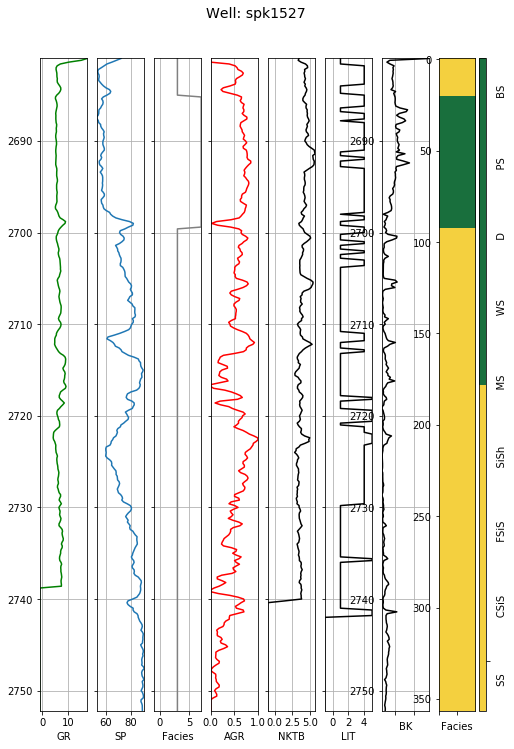

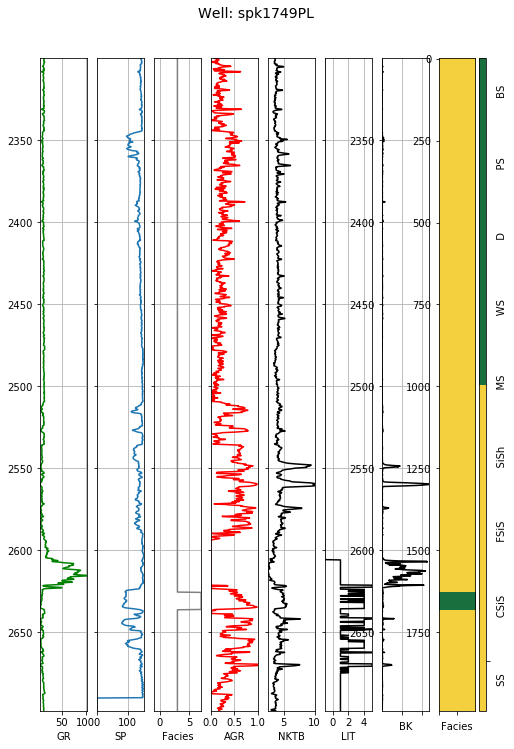

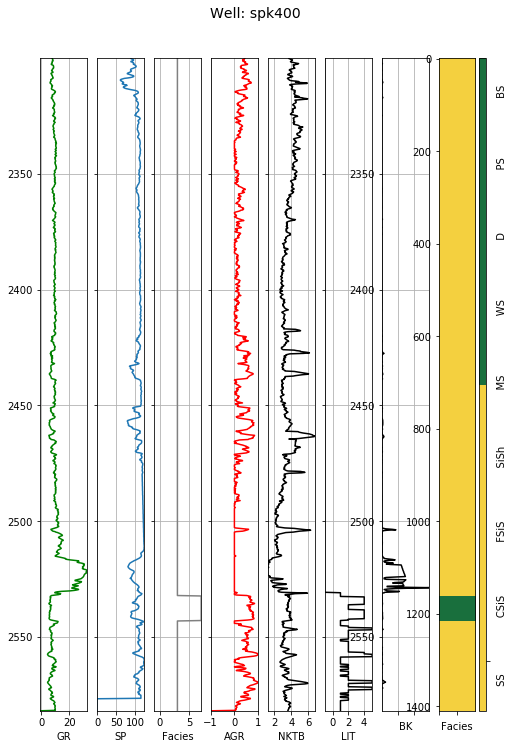

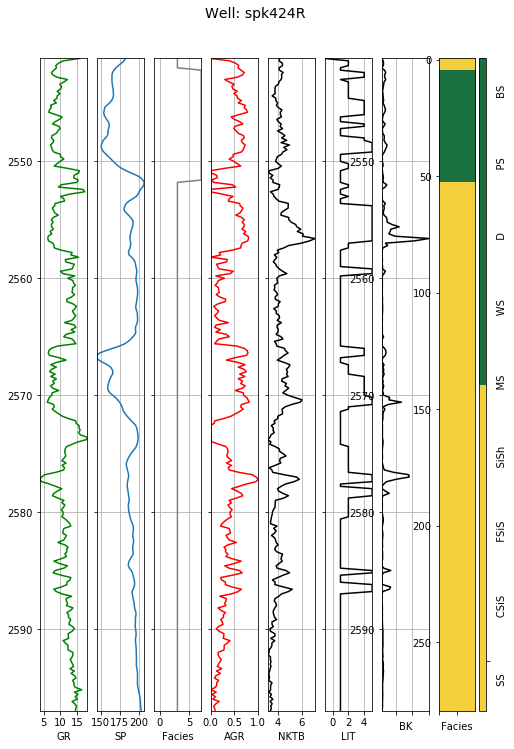

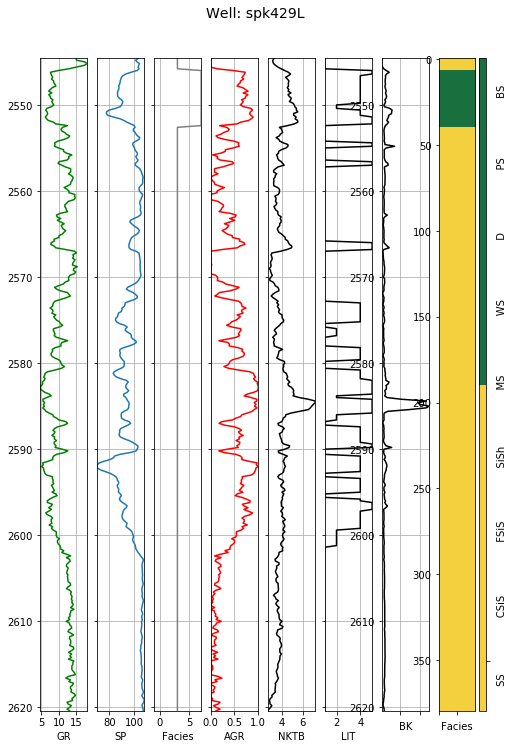

In [18]:
def get_wells_with_7_facies(wells_all):
    wells_7_namens = wells_all[wells_all['Facies'] == 7]['wellName'].unique()
    print(wells_7_namens)
    wells = []
    for name in wells_7_namens:
        well = wells_all[wells_all['wellName'] == name]
        wells.append(well)
    return wells


def make_facies_log_plot(logs):
    facies_colors = ['#F4D03F', '#196F3D']
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    mpl.rcParams['figure.figsize'] = (20.0, 10.0)
    import matplotlib.colors as colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    # make sure logs are sorted by depth
    logs = logs.sort_values(by='MD')
    cmap_facies = colors.ListedColormap(
        facies_colors[0:len(facies_colors)], 'indexed')

    ztop = logs.MD.min()
    zbot = logs.MD.max()

    cluster = np.repeat(np.expand_dims(logs['Facies'].values, 1), 100, 1)
#     print(np.expand_dims(logs['Facies'].values, 1))
#     print(cluster)

    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.MD, '-g')
    ax[1].plot(logs.SP, logs.MD, '-')
    ax[2].plot(logs.Facies, logs.MD, '-', color='0.5')
    ax[3].plot(logs.AGR, logs.MD, '-', color='r')
    ax[4].plot(logs.NKTB, logs.MD, '-', color='black')
    ax[5].plot(logs.LIT, logs.MD, '-', color='black')
    ax[6].plot(logs.BK, logs.MD, '-', color='black')

    facies_index = 7
    im = ax[facies_index].imshow(cluster, interpolation='none', aspect='auto',
                      cmap=cmap_facies, vmin=-1, vmax=12)
    divider = make_axes_locatable(ax[facies_index])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label((17 * ' ').join([' SS ', 'CSiS', 'FSiS',
                                    'SiSh', ' MS ', ' WS ', ' D  ',
                                    ' PS ', ' BS ']))
    cbar.set_ticks(range(0, 1))
    cbar.set_ticklabels('')

    for i in range(len(ax) - 1):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(), logs.GR.max())
    ax[1].set_xlabel("SP")
    ax[1].set_xlim(logs.SP.min(), logs.SP.max())
    ax[2].set_xlabel("Facies")
    ax[2].set_xlim(-1, logs.Facies.max())
    ax[3].set_xlabel("AGR")
    ax[3].set_xlim(logs.AGR.min(), logs.AGR.max())
    ax[4].set_xlabel("NKTB")
    ax[4].set_xlim(logs.NKTB.min(), logs.NKTB.max())
    ax[5].set_xlabel("LIT")
    ax[5].set_xlim(logs.LIT.min(), logs.LIT.max())
    ax[6].set_xlabel("BK")
    ax[6].set_xlim(logs.BK.min(), logs.BK.max())
    ax[facies_index].set_xlabel('Facies')
    

    ax[1].set_yticklabels([]);
    ax[2].set_yticklabels([]);
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[5].set_yticklabels([])
    ax[6].set_xticklabels([])
    ax[facies_index].set_xticklabels([])
    f.suptitle('Well: %s' % logs.iloc[0]['wellName'], fontsize=14, y=0.94)

def view_facies(wells_7_dfs):
    for well in wells_7_dfs:
        make_facies_log_plot(well[well['MD'] > 2300])

wells_7_dfs = get_wells_with_7_facies(for_ml)
view_facies(wells_7_dfs)

In [4]:

# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

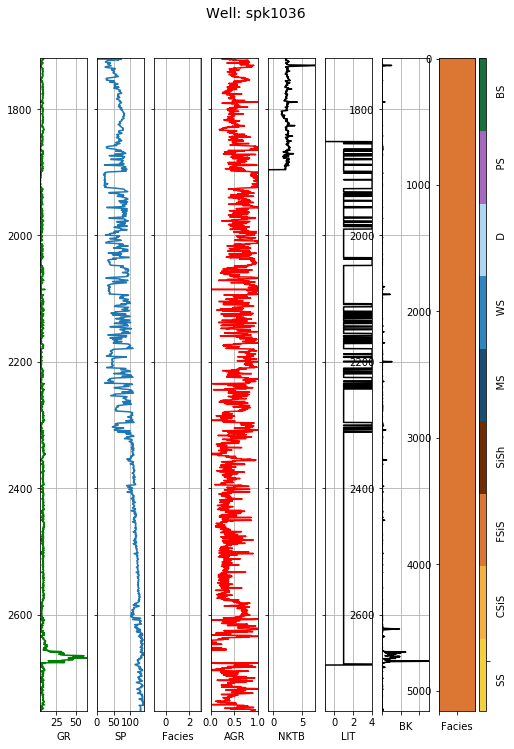

In [7]:

def make_facies_log_plot(logs):
    facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    mpl.rcParams['figure.figsize'] = (20.0, 10.0)
    import matplotlib.colors as colors
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    # make sure logs are sorted by depth
    logs = logs.sort_values(by='MD')
    cmap_facies = colors.ListedColormap(
        facies_colors[0:len(facies_colors)], 'indexed')

    ztop = logs.MD.min()
    zbot = logs.MD.max()

    cluster = np.repeat(np.expand_dims(logs['Facies'].values, 1), 100, 1)
#     print(np.expand_dims(logs['Facies'].values, 1))
#     print(cluster)

    f, ax = plt.subplots(nrows=1, ncols=8, figsize=(8, 12))
    ax[0].plot(logs.GR, logs.MD, '-g')
    ax[1].plot(logs.SP, logs.MD, '-')
    ax[2].plot(logs.Facies, logs.MD, '-', color='0.5')
    ax[3].plot(logs.AGR, logs.MD, '-', color='r')
    ax[4].plot(logs.NKTB, logs.MD, '-', color='black')
    ax[5].plot(logs.LIT, logs.MD, '-', color='black')
    ax[6].plot(logs.BK, logs.MD, '-', color='black')

    facies_index = 7
    im = ax[facies_index].imshow(cluster, interpolation='none', aspect='auto',
                      cmap=cmap_facies, vmin=-1, vmax=12)
    divider = make_axes_locatable(ax[facies_index])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label((17 * ' ').join([' SS ', 'CSiS', 'FSiS',
                                    'SiSh', ' MS ', ' WS ', ' D  ',
                                    ' PS ', ' BS ']))
    cbar.set_ticks(range(0, 1))
    cbar.set_ticklabels('')

    for i in range(len(ax) - 1):
        ax[i].set_ylim(ztop, zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)

    ax[0].set_xlabel("GR")
    ax[0].set_xlim(logs.GR.min(), logs.GR.max())
    ax[1].set_xlabel("SP")
    ax[1].set_xlim(logs.SP.min(), logs.SP.max())
    ax[2].set_xlabel("Facies")
    ax[2].set_xlim(-1, logs.Facies.max())
    ax[3].set_xlabel("AGR")
    ax[3].set_xlim(logs.AGR.min(), logs.AGR.max())
    ax[4].set_xlabel("NKTB")
    ax[4].set_xlim(logs.NKTB.min(), logs.NKTB.max())
    ax[5].set_xlabel("LIT")
    ax[5].set_xlim(logs.LIT.min(), logs.LIT.max())
    ax[6].set_xlabel("BK")
    ax[6].set_xlim(logs.BK.min(), logs.BK.max())
    ax[facies_index].set_xlabel('Facies')
    

    ax[1].set_yticklabels([]);
    ax[2].set_yticklabels([]);
    ax[3].set_yticklabels([])
    ax[4].set_yticklabels([]);
    ax[5].set_yticklabels([])
    ax[6].set_xticklabels([])
    ax[facies_index].set_xticklabels([])
    f.suptitle('Well: %s' % logs.iloc[0]['wellName'], fontsize=14, y=0.94)

well = wells_samples_df[0][wells_samples_df[0]['MD'] >= 1600]
make_facies_log_plot(
    well)

In [48]:
for_ml_16 = for_ml[for_ml['Facies'] == 7]['wellName'].unique()
print(for_ml_16)

['spk1519' 'spk1521' 'spk1527' 'spk1749PL' 'spk400' 'spk424R' 'spk429L']


In [50]:
test = ['spk1521', 'spk1527', 'spk400', 'spk424R', 'spk428R', 'spk429L',
       'spk432R']
for _ in test:
    if _ not in for_ml_16:
        print(_)

spk428R
spk432R


In [51]:
spk428R = for_ml[for_ml['wellName'] == 'spk428R']

In [54]:
spk428R[spk428R['MD'] > 2598]

wellName      MD       AGR       ANK       ASP     BK  Facies  \
75622  spk428R  2598.2  0.422105  0.840100  0.040139  10.64       5   
75623  spk428R  2598.4  0.507368  0.838600  0.074203   9.67       5   
75624  spk428R  2598.6  0.567368  0.760590  0.075006   9.09       5   
75625  spk428R  2598.8  0.523158  0.738087  0.044147   9.02       5   
75626  spk428R  2599.0  0.389474  0.829599  0.018981   9.42       5   
...        ...     ...       ...       ...       ...    ...     ...   
75855  spk428R  2644.8  0.141053  0.969117  0.020381   8.77   -9999   
75856  spk428R  2645.0  0.110526  0.958616  0.024582   8.64   -9999   
75857  spk428R  2645.2  0.110526  0.973618  0.023688   8.51   -9999   
75858  spk428R  2645.4  0.123158  0.970618  0.030986   8.58   -9999   
75859  spk428R  2645.6  0.088421  0.943614  0.036485   8.32   -9999   

       Facies_LIT     GR LAYER  LIT   NKTB       SP  
75622       -9999  11.43    U1  1.0  3.627  152.069  
75623       -9999  10.62    U1  2.0  3.634  148.659  
75624       -9999  10.05    U1  2.0  3.998  148.579  
75625       -9999  10.47    U1  2.0  4.103  151.668  
75626       -9999  11.74    U1  1.0  3.676  154.188  
...           ...    ...   ...  ...    ...      ...  
75855       -9999  14.10    U1  1.0  3.025  154.048  
75856       -9999  14.39    U1  1.0  3.074  153.627  
75857       -9999  14.39    U1  1.0  3.004  153.716  
75858       -9999  14.27    U1  1.0  3.018  152.986  
75859       -9999  14.60    U1  1.0  3.144  152.435  

[238 rows x 13 columns]

In [55]:
spk432R = for_ml[for_ml['wellName'] == 'spk432R']

In [58]:
spk432R[spk432R['MD'] >= 2616]

wellName      MD       AGR       ANK       ASP     BK  Facies  \
76360  spk432R  2616.0  0.410179  0.946087  0.032348  9.517   -9999   
76361  spk432R  2616.2  0.512319  0.963010  0.064929  8.028   -9999   
76362  spk432R  2616.4  0.682938  0.862281  0.123798  7.723   -9999   
76363  spk432R  2616.6  0.776403  0.754300  0.151446  8.021   -9999   
76364  spk432R  2616.8  0.658762  0.751210  0.164333  8.448   -9999   
...        ...     ...       ...       ...       ...    ...     ...   
76602  spk432R  2664.4  0.234586  1.000000  0.000000  5.869   -9999   
76603  spk432R  2664.6  0.274610  1.000000  0.000000  6.166   -9999   
76604  spk432R  2664.8  0.203586  1.000000  0.000000  7.917   -9999   
76605  spk432R  2665.0  0.107808  1.000000  0.000000  8.308   -9999   
76606  spk432R  2665.2  0.110353  1.000000  0.000000  8.206   -9999   

       Facies_LIT      GR LAYER  LIT     NKTB       SP  
76360       -9999  12.734    U1  1.0  3.47244  193.489  
76361       -9999  11.851    U1  1.0  3.39709  190.234  
76362       -9999  10.376    U1  2.0  3.84560  184.351  
76363       -9999   9.568    U1  2.0  4.32641  181.588  
76364       -9999  10.585    U1  2.0  4.34016  180.300  
...           ...     ...   ...  ...      ...      ...  
76602       -9999  14.252    U1  1.0  3.15011  198.362  
76603       -9999  13.906    U1  1.0  3.06579  198.828  
76604       -9999  14.520    U1  1.0  2.98865  198.490  
76605       -9999  15.348    U1  1.0  2.54313  198.255  
76606       -9999  15.326    U1  1.0  2.50426  198.267  

[247 rows x 13 columns]

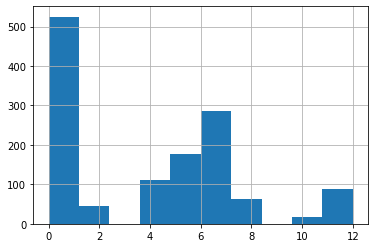

In [4]:
for_ml[for_ml['Facies_LIT'] > -1]['Facies_LIT'].hist()

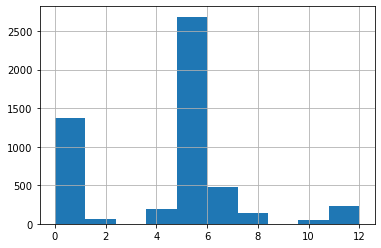

In [5]:
for_ml[for_ml['Facies'] > -1]['Facies'].hist()

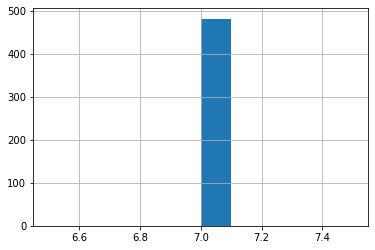

In [6]:
for_ml[for_ml['Facies'] == 7]['Facies'].hist()

In [7]:
for_ml[for_ml['Facies'] == 7]['wellName'].unique()

array(['spk1519', 'spk1521', 'spk1527', 'spk1749PL', 'spk400', 'spk424R',
       'spk429L'], dtype=object)

In [8]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['interval_lenght_' + new_feature_prefix] = interval_df_[feature_names[0]].count()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
#             if part[name].max() == part[name].min():
#                 part['std_' + new_feature_prefix + name] = 0
#             else:
#                 part['std_' + new_feature_prefix + name] = part[name].std()
#             part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)

def min_shift_corrector(middle_interval_dfs, shift_corrector):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            ppart[name] = part[name] - abs(shift_corrector)
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_distance_features__(well):
    def add_feature_last(well_in, shift_last, name):
        well_in[name + '_last_' + str(shift_last / 5)] = well_in[name].shift(periods=-shift_last)

    def add_feature_next(well_in, shift_next, name):
        well_in[name + '_next_' + str(shift_next / 5)] = well_in[name].shift(periods=+shift_next)

    distance_meter = [3, 6, 9, 12, 15]
    distance_shift = [meter * 5 for meter in distance_meter]
    well_copy = well.copy()

    for shift in distance_shift:
        add_feature_last(well_copy, shift, 'GR')
        add_feature_last(well_copy, shift, 'BK')
        add_feature_last(well_copy, shift, 'NKTB')

        add_feature_next(well_copy, shift, 'GR')
        add_feature_next(well_copy, shift, 'BK')
        add_feature_next(well_copy, shift, 'NKTB')

    return well_copy


def get_well_with_features_df_intervals(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()
        name_feature_extraction = feature_names[0] + '_savitzky_golay'
        print(feature_names[0] + '_' + str(index_well))
        well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 4, 1, 1)
        index_well = index_well + 1

        for border in percents_borders:
            new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
            well_copy = get_with_interval_feature_extraction(well=well_copy,
                                                             features_name_for_extraction=name_feature_extraction,
                                                             percent_change_border=border,
                                                             new_feature_prefix=new_feature_prefix,
                                                             features_name_for_statistic=feature_names)
        
#         upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
#                         timeperiod=2,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['SP_upper'] = upper
#         well_copy['SP_middle'] = middle
#         well_copy['SP_lower'] = lower
        

        
        del well_copy[name_feature_extraction]
        well_copy = get_well_with_distance_features__(well_copy)
        well_copy.fillna(-9999)
        wells_return.append(well_copy)

    print(len(wells_nulls))
    return wells_return


#well_with_features = get_well_with_features_df_intervals(wells_samples_df, ['SP'], [0.2])
well_with_features = get_well_with_features_df_intervals(wells_samples_df, ['GR'], [0.2, 0.15])

GR_0
GR_1


C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\iteration2\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
GR_18
GR_19
GR_20
GR_21
GR_22
GR_23
GR_24
GR_25
GR_26
0


In [13]:




def change_facies(x):
    undefined_value = -9999
    if x == 7:
        return x
    return 3
    if x > -1:
        return 3
    return x

def get_sorted_columns(df):
    result = pd.DataFrame()
    columns_all = df.columns
    #print(columns_all)
    sorted_columns = sorted(columns_all)
    for feature_name in sorted_columns:
        result[feature_name] = df[feature_name]
    return result

for_ml_preprocessing = pd.concat(well_with_features)

for_ml_preprocessing['Facies'] = for_ml_preprocessing['Facies'].apply(change_facies)
for_ml_preprocessing = get_sorted_columns(for_ml_preprocessing)
for_ml_preprocessing = for_ml_preprocessing.fillna(-9999)


def get_features_filtering(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] > -1]
    del well_copy['LAYER']
    del well_copy['Facies_LIT']
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies' and name_feature != 'LAYER'):
            #print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -299]
    return well_copy.dropna()


for_ml_with_features = for_ml_preprocessing#get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())


def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LAYER']
    del feature['Facies_LIT']
    #del feature['LIT']
    del feature['MD']
    
    del feature['SP']
    del feature['ASP']
    
#     del feature['AGR']
#     del feature['ANK']
#     del feature['ASP']

    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

def getLog(df):
    import math
    def change_null(x):
        undefined_value = -1
        if x == 'NaN':
            return undefined_value
        if math.isnan(x):
            return undefined_value
        if math.isinf(x):
            return undefined_value
        return x

    def change_null_(x):
        if x < 0:
            return -np.log(abs(x))
        if x == 0:
            return 0
        return np.log(abs(x))

    df_copy = df.copy()
    columns = df_copy.columns


    for col in columns:
        df_copy[col] = df_copy[col].apply(change_null)
        dif = df_copy[col] < 0
        if dif.count() > 1:
            print(df_copy[col].mean())
            if abs(df_copy[col].mean()) + df_copy[col].std() > 10:
                df_copy[col] = df_copy[col].apply(change_null_) 

    corr_matrix = df_copy.corr().abs()
    display(corr_matrix)
    return df_copy

features_no_preprocessing = get_for_learn_featres(for_ml_with_features)
features = features_no_preprocessing
target_facies = get_for_learn_target_class(for_ml_with_features)

display(features)

AGR           ANK           ASP             BK  BK_last_12.0  \
count  76266.000000  76266.000000  76266.000000   76266.000000   76266.00000   
mean     -44.764379  -6134.433394   -791.884994   -2768.068426   -2946.42391   
std      671.026058   4869.337854   2700.685399    4577.143865    4659.67871   
min    -9999.000000  -9999.000000  -9999.000000   -9999.000000   -9999.00000   
25%        0.255698  -9999.000000      0.026217   -9999.000000   -9999.00000   
50%        0.470404  -9999.000000      0.131608       5.909000       5.78200   
75%        0.669281      0.810899      0.407603       7.900000       7.80000   
max        1.000000      1.000000      1.000000  116144.860000  116144.86000   

        BK_last_15.0    BK_last_3.0    BK_last_6.0    BK_last_9.0  \
count   76266.000000   76266.000000   76266.000000   76266.000000   
mean    -2991.699049   -2810.586163   -2855.867334   -2901.148754   
std      4679.319541    4597.586333    4618.819260    4639.512929   
min     -9999.000000   -9999.000000   -9999.000000   -9999.000000   
25%     -9999.000000   -9999.000000   -9999.000000   -9999.000000   
50%         5.730000       5.897650       5.840100       5.800000   
75%         7.800000       7.888450       7.859950       7.826600   
max    116144.860000  116144.860000  116144.860000  116144.860000   

        BK_next_12.0  ...  NKTB_next_3.0  NKTB_next_6.0  NKTB_next_9.0  \
count   76266.000000  ...   76266.000000   76266.000000   76266.000000   
mean    -2944.695934  ...    -649.826515    -693.109063    -738.227882   
std      4658.942536  ...    2472.417506    2547.025135    2621.778878   
min     -9999.000000  ...   -9999.000000   -9999.000000   -9999.000000   
25%     -9999.000000  ...       3.275792       3.268150       3.259800   
50%         5.770000  ...       3.718800       3.715450       3.710225   
75%         7.800000  ...       4.259400       4.256730       4.252955   
max    116144.860000  ...      24.130000      24.130000      24.130000   

                 SP  interval_lenght_GRinterval_0.15_  \
count  76266.000000                      76266.000000   
mean    -150.435751                         23.120657   
std     1597.217798                         56.054276   
min    -9999.000000                          1.000000   
25%       75.192780                          6.000000   
50%      107.352500                         14.000000   
75%      139.822250                         25.000000   
max      218.061000                        612.000000   

       interval_lenght_GRinterval_0.2_  max_GRinterval_0.15_GR  \
count                     76266.000000            76266.000000   
mean                         24.996158               10.047921   
std                          60.291521              149.792797   
min                           1.000000            -9999.000000   
25%                           6.000000                8.816000   
50%                          15.000000               11.150000   
75%                          28.000000               13.080000   
max                         644.000000              108.920000   

       max_GRinterval_0.2_GR  min_GRinterval_0.15_GR  min_GRinterval_0.2_GR  
count           76266.000000            76266.000000           76266.000000  
mean               10.102189              -60.434051             -60.489251  
std               149.794817              828.258266             828.253594  
min             -9999.000000            -9999.000000           -9999.000000  
25%                 8.900000                6.200000               6.150000  
50%                11.239000                7.795000               7.730000  
75%                13.117200                9.936750               9.860000  
max               108.920000               91.353000              91.353000  

[8 rows x 47 columns]

AGR          ANK      BK  BK_last_12.0  BK_last_15.0  \
0         0.433027 -9999.000000 -9999.0           6.2           6.6   
1         0.390320 -9999.000000 -9999.0           6.2           6.6   
2         0.317364 -9999.000000 -9999.0           6.0           6.5   
17        0.721295 -9999.000000 -9999.0           6.2           6.6   
18        0.767560 -9999.000000 -9999.0           6.6           6.8   
...            ...          ...     ...           ...           ...   
68715     0.655048     0.641971 -9999.0       -9999.0       -9999.0   
68717 -9999.000000     0.684508 -9999.0       -9999.0       -9999.0   
68719 -9999.000000     0.748848 -9999.0       -9999.0       -9999.0   
68721 -9999.000000     0.745647 -9999.0       -9999.0       -9999.0   
68723 -9999.000000 -9999.000000 -9999.0       -9999.0       -9999.0   

       BK_last_3.0  BK_last_6.0  BK_last_9.0  BK_next_12.0  BK_next_15.0  ...  \
0              7.7          8.3        33.60       -9999.0       -9999.0  ...   
1              7.6          7.9        31.10       -9999.0       -9999.0  ...   
2              7.6          7.9        13.42       -9999.0       -9999.0  ...   
17             8.0          8.1         8.10       -9999.0       -9999.0  ...   
18             8.5          8.2         7.40       -9999.0       -9999.0  ...   
...            ...          ...          ...           ...           ...  ...   
68715      -9999.0      -9999.0     -9999.00       -9999.0       -9999.0  ...   
68717      -9999.0      -9999.0     -9999.00       -9999.0       -9999.0  ...   
68719      -9999.0      -9999.0     -9999.00       -9999.0       -9999.0  ...   
68721      -9999.0      -9999.0     -9999.00       -9999.0       -9999.0  ...   
68723      -9999.0      -9999.0     -9999.00       -9999.0       -9999.0  ...   

       NKTB_next_15.0  NKTB_next_3.0  NKTB_next_6.0  NKTB_next_9.0  \
0         -9999.00000    -9999.00000    -9999.00000    -9999.00000   
1         -9999.00000    -9999.00000    -9999.00000    -9999.00000   
2         -9999.00000    -9999.00000    -9999.00000    -9999.00000   
17        -9999.00000    -9999.00000    -9999.00000    -9999.00000   
18        -9999.00000    -9999.00000    -9999.00000    -9999.00000   
...               ...            ...            ...            ...   
68715         4.16013        4.19950        3.99895        3.37263   
68717         3.83410        4.14437        4.06930        3.45925   
68719         3.50493        4.13440        3.97480        3.65823   
68721         3.11013        4.23572        3.97113        3.82308   
68723         2.68750        4.34335        3.82465        3.83253   

       interval_lenght_GRinterval_0.15_  interval_lenght_GRinterval_0.2_  \
0                                     3                                3   
1                                     3                                3   
2                                     3                                3   
17                                    3                                6   
18                                    3                                6   
...                                 ...                              ...   
68715                                21                               21   
68717                                21                               21   
68719                                21                               21   
68721                                21                               21   
68723                                21                               21   

       max_GRinterval_0.15_GR  max_GRinterval_0.2_GR  min_GRinterval_0.15_GR  \
0                       7.860                  7.860                    7.21   
1                       7.860                  7.860                    7.21   
2                       7.860                  7.860                    7.21   
17                      5.810                  6.220                    5.33   
18                      5.810      

In [14]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18)
    model = model.fit(X_train, y_train)
    p(y_test, model.predict(X_test))
    p_cross_val(model, train, labels)
    return model

logistic_regression(getLog(features), target_facies)  

-44.764379014199335
-6134.433394269736
-2768.0684263061853
-2946.423909729969
-2991.6990486581817
-2810.586163439371
-2855.8673343169526
-2901.148753581755
-2944.695933896724
-2989.970450645995
-2809.0085591412594
-2854.150042163838
-2899.423400788259
-43.893568759342614
-254.11886886030624
-307.26499372853135
-95.0736579904563
-147.82387450371297
-200.97164528361185
-224.2480579039162
-272.41663336742573
-85.76892652426842
-131.05455194582368
-176.99650435187368
-6422.432184695671
-607.0684009274655
-814.8234761468285
-867.9423520075129
-656.909484607742
-708.5860425026106
-761.7048222710523
-783.4780702760756
-831.745093989277
-649.8265146924466
-693.10906331136
-738.2278817307078
23.12065664909658
24.9961581832009
10.047920852018734
10.102189120972138
-60.43405127973126
-60.48925066084436


AGR       ANK        BK  BK_last_12.0  \
AGR                               1.000000  0.007174  0.028395      0.023305   
ANK                               0.007174  1.000000  0.435889      0.447024   
BK                                0.028395  0.435889  1.000000      0.947319   
BK_last_12.0                      0.023305  0.447024  0.947319      1.000000   
BK_last_15.0                      0.032093  0.450687  0.936263      0.984050   
BK_last_3.0                       0.019500  0.438698  0.982663      0.959832   
BK_last_6.0                       0.003382  0.441525  0.970436      0.971803   
BK_last_9.0                       0.010977  0.444325  0.958736      0.983886   
BK_next_12.0                      0.049919  0.448310  0.946733      0.902247   
BK_next_15.0                      0.051999  0.451501  0.935817      0.891935   
BK_next_3.0                       0.040608  0.438966  0.982198      0.934263   
BK_next_6.0                       0.044897  0.442024  0.969860      0.923368   
BK_next_9.0                       0.047128  0.445259  0.958082      0.912717   
GR                                0.297560  0.115634  0.108413      0.046599   
GR_last_12.0                      0.247864  0.001679  0.094451      0.132398   
GR_last_15.0                      0.238249  0.015903  0.096852      0.117634   
GR_last_3.0                       0.282200  0.066927  0.090909      0.024552   
GR_last_6.0                       0.264535  0.037225  0.090131      0.070855   
GR_last_9.0                       0.255846  0.015427  0.091853      0.105633   
GR_next_12.0                      0.038539  0.009418  0.091944      0.087491   
GR_next_15.0                      0.011882  0.025318  0.093819      0.092680   
GR_next_3.0                       0.195388  0.070151  0.095547      0.061752   
GR_next_6.0                       0.120600  0.035980  0.092201      0.071946   
GR_next_9.0                       0.075913  0.010101  0.091433      0.081104   
LIT                               0.031784  0.001120  0.325606      0.286522   
NKTB                              0.082413  0.210987  0.156957      0.133765   
NKTB_last_12.0                    0.114505  0.145892  0.159642      0.027409   
NKTB_last_15.0                    0.118437  0.132589  0.161032      0.031256   
NKTB_last_3.0                     0.101739  0.192749  0.156423      0.104253   
NKTB_last_6.0                     0.101814  0.175623  0.157224      0.076282   
NKTB_last_9.0                     0.107672  0.160177  0.158335      0.051868   
NKTB_next_12.0                    0.018234  0.142322  0.155587      0.152466   
NKTB_next_15.0                    0.028451  0.128531  0.156513      0.154264   
NKTB_next_3.0                     0.042612  0.192165  0.155885      0.139378   
NKTB_next_6.0                     0.013363  0.174308  0.155572      0.144746   
NKTB_next_9.0                     0.002445  0.157590  0.155593      0.148718   
interval_lenght_GRinterval_0.15_  0.021843  0.047483  0.068371      0.071952   
interval_lenght_GRinterval_0.2_   0.017808  0.042728  0.062490      0.063587   
max_GRinterval_0.15_GR            0.067876  0.098407  0.113314      0.128595   
max_GRinterval_0.2_GR             0.063801  0.097725  0.111118      0.126370   
min_GRinterval_0.15_GR            0.279030  0.104315  0.100733      0.039087   
min_GRinterval_0.2_GR             0.276718  0.105661  0.102016      0.041652   

                                  BK_last_15.0  BK_last_3.0  BK_last_6.0  \
AGR                                   0.032093     0.019500     0.003382   
ANK                                   0.450687     0.438698     0.441525   
BK                                    0.936263     0.982663     0.970436   
BK_last_12.0                          0.984050     0.959832     0.971803   
BK_last_15.0                          1.000000     0.948471     0.960209   
BK_last_3.0                           0.948471     1.000000     0.983532   
BK_last_6.0                           0.960209     0.983532     1.

logistic_regression


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


RMSE ошибка равна 0.0958041958041958
              precision    recall  f1-score   support

           3       0.99      1.00      1.00     22730
           7       0.66      0.18      0.28       150

    accuracy                           0.99     22880
   macro avg       0.83      0.59      0.64     22880
weighted avg       0.99      0.99      0.99     22880

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

              precision    recall  f1-score   support

           3       0.99      0.98      0.99     75800
           7       0.05      0.14      0.07       466

    accuracy                           0.98     76266
   macro avg       0.52      0.56      0.53     76266
weighted avg       0.99      0.98      0.98     76266



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=18, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [17]:
def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    ridge_model = RidgeClassifier(random_state = 18)
    ridge_model.fit(train, labels)
    p(y_test, ridge_model.predict(X_test))
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(features, target_facies)

RMSE ошибка равна 0.1048951048951049
              precision    recall  f1-score   support

           3       0.99      1.00      1.00     22730
           7       0.00      0.00      0.00       150

    accuracy                           0.99     22880
   macro avg       0.50      0.50      0.50     22880
weighted avg       0.99      0.99      0.99     22880

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.99      1.00      1.00     75800
           7       0.00      0.00      0.00       466

    accuracy                           0.99     76266
   macro avg       0.50      0.50      0.50     76266
weighted avg       0.99      0.99      0.99     76266



RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [85]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=10)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

 n_neighbors 
1
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     22746
           7       0.84      0.88      0.86       134

    accuracy                           1.00     22880
   macro avg       0.92      0.94      0.93     22880
weighted avg       1.00      1.00      1.00     22880



KeyboardInterrupt: 

In [21]:
def get_KNeighborsClassifier(train, labels):
    classifier = KNeighborsClassifier(n_neighbors=1)
    classifier.fit(train, labels)
    p(labels, classifier.predict(train))
    p_cross_val(classifier, train, labels)
    return classifier

KNeighbors_model_prod = get_KNeighborsClassifier(getLog(features), target_facies)

-44.764379014199335
-6134.433394269736
-2768.0684263061853
-2946.423909729969
-2991.6990486581817
-2810.586163439371
-2855.8673343169526
-2901.148753581755
-2944.695933896724
-2989.970450645995
-2809.0085591412594
-2854.150042163838
-2899.423400788259
-43.893568759342614
-254.11886886030624
-307.26499372853135
-95.0736579904563
-147.82387450371297
-200.97164528361185
-224.2480579039162
-272.41663336742573
-85.76892652426842
-131.05455194582368
-176.99650435187368
-6422.432184695671
-607.0684009274655
-814.8234761468285
-867.9423520075129
-656.909484607742
-708.5860425026106
-761.7048222710523
-783.4780702760756
-831.745093989277
-649.8265146924466
-693.10906331136
-738.2278817307078
23.12065664909658
24.9961581832009
10.047920852018734
10.102189120972138
-60.43405127973126
-60.48925066084436


AGR       ANK        BK  BK_last_12.0  \
AGR                               1.000000  0.007174  0.028395      0.023305   
ANK                               0.007174  1.000000  0.435889      0.447024   
BK                                0.028395  0.435889  1.000000      0.947319   
BK_last_12.0                      0.023305  0.447024  0.947319      1.000000   
BK_last_15.0                      0.032093  0.450687  0.936263      0.984050   
BK_last_3.0                       0.019500  0.438698  0.982663      0.959832   
BK_last_6.0                       0.003382  0.441525  0.970436      0.971803   
BK_last_9.0                       0.010977  0.444325  0.958736      0.983886   
BK_next_12.0                      0.049919  0.448310  0.946733      0.902247   
BK_next_15.0                      0.051999  0.451501  0.935817      0.891935   
BK_next_3.0                       0.040608  0.438966  0.982198      0.934263   
BK_next_6.0                       0.044897  0.442024  0.969860      0.923368   
BK_next_9.0                       0.047128  0.445259  0.958082      0.912717   
GR                                0.297560  0.115634  0.108413      0.046599   
GR_last_12.0                      0.247864  0.001679  0.094451      0.132398   
GR_last_15.0                      0.238249  0.015903  0.096852      0.117634   
GR_last_3.0                       0.282200  0.066927  0.090909      0.024552   
GR_last_6.0                       0.264535  0.037225  0.090131      0.070855   
GR_last_9.0                       0.255846  0.015427  0.091853      0.105633   
GR_next_12.0                      0.038539  0.009418  0.091944      0.087491   
GR_next_15.0                      0.011882  0.025318  0.093819      0.092680   
GR_next_3.0                       0.195388  0.070151  0.095547      0.061752   
GR_next_6.0                       0.120600  0.035980  0.092201      0.071946   
GR_next_9.0                       0.075913  0.010101  0.091433      0.081104   
LIT                               0.031784  0.001120  0.325606      0.286522   
NKTB                              0.082413  0.210987  0.156957      0.133765   
NKTB_last_12.0                    0.114505  0.145892  0.159642      0.027409   
NKTB_last_15.0                    0.118437  0.132589  0.161032      0.031256   
NKTB_last_3.0                     0.101739  0.192749  0.156423      0.104253   
NKTB_last_6.0                     0.101814  0.175623  0.157224      0.076282   
NKTB_last_9.0                     0.107672  0.160177  0.158335      0.051868   
NKTB_next_12.0                    0.018234  0.142322  0.155587      0.152466   
NKTB_next_15.0                    0.028451  0.128531  0.156513      0.154264   
NKTB_next_3.0                     0.042612  0.192165  0.155885      0.139378   
NKTB_next_6.0                     0.013363  0.174308  0.155572      0.144746   
NKTB_next_9.0                     0.002445  0.157590  0.155593      0.148718   
interval_lenght_GRinterval_0.15_  0.021843  0.047483  0.068371      0.071952   
interval_lenght_GRinterval_0.2_   0.017808  0.042728  0.062490      0.063587   
max_GRinterval_0.15_GR            0.067876  0.098407  0.113314      0.128595   
max_GRinterval_0.2_GR             0.063801  0.097725  0.111118      0.126370   
min_GRinterval_0.15_GR            0.279030  0.104315  0.100733      0.039087   
min_GRinterval_0.2_GR             0.276718  0.105661  0.102016      0.041652   

                                  BK_last_15.0  BK_last_3.0  BK_last_6.0  \
AGR                                   0.032093     0.019500     0.003382   
ANK                                   0.450687     0.438698     0.441525   
BK                                    0.936263     0.982663     0.970436   
BK_last_12.0                          0.984050     0.959832     0.971803   
BK_last_15.0                          1.000000     0.948471     0.960209   
BK_last_3.0                           0.948471     1.000000     0.983532   
BK_last_6.0                           0.960209     0.983532     1.

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     75800
           7       1.00      1.00      1.00       466

    accuracy                           1.00     76266
   macro avg       1.00      1.00      1.00     76266
weighted avg       1.00      1.00      1.00     76266

cross_val_predict
              precision    recall  f1-score   support

           3       1.00      0.98      0.99     75800
           7       0.13      0.44      0.20       466

    accuracy                           0.98     76266
   macro avg       0.56      0.71      0.59     76266
weighted avg       0.99      0.98      0.98     76266



In [19]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
#get_gradientBoostingClassifier(features, target_facies) 

RMSE ошибка равна 0.0619588391419745
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     22864
           7       0.67      0.49      0.57       119

    accuracy                           1.00     22983
   macro avg       0.84      0.74      0.78     22983
weighted avg       1.00      1.00      1.00     22983

cross_val_predict
              precision    recall  f1-score   support

           3       1.00      0.99      0.99     76126
           7       0.16      0.31      0.21       481

    accuracy                           0.99     76607
   macro avg       0.58      0.65      0.60     76607
weighted avg       0.99      0.99      0.99     76607



GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=18, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [22]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True,criterion='entropy',
            n_estimators=500, n_jobs=-1,warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    
    p(labels, OVR.predict(train).round())
    p_cross_val(OVR, train, labels)
    OVR.fit(train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

RMSE ошибка равна 0.0
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     75800
           7       1.00      1.00      1.00       466

    accuracy                           1.00     76266
   macro avg       1.00      1.00      1.00     76266
weighted avg       1.00      1.00      1.00     76266

cross_val_predict
              precision    recall  f1-score   support

           3       0.99      1.00      1.00     75800
           7       0.62      0.12      0.20       466

    accuracy                           0.99     76266
   macro avg       0.81      0.56      0.60     76266
weighted avg       0.99      0.99      0.99     76266



In [23]:
def get_OneVsRestClassifier_randomForestRegressor(train, labels):
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
    
    reg = RandomForestClassifier(random_state = 18, bootstrap=True,criterion='entropy',
            n_estimators=500, n_jobs=-1,warm_start=False)

    OVR = OneVsRestClassifier(reg,n_jobs=-1)
    OVR.fit(train, labels)
    return OVR

prod_OneVsRest_RandomForest_model = get_OneVsRestClassifier_randomForestRegressor(features, target_facies) 

In [24]:
def get_cb_data_all(train, labels):
    from catboost import CatBoostClassifier, Pool, cv
    train_copy = train.copy()
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            train_copy[_] = train_copy[_].apply(lambda x: str(x))
            cat_features.append(index)
        index +=1
    #print(cat_features)
    #print(train_copy)
    cv_dataset = Pool(data=train_copy,
                      label=labels,
                      cat_features=cat_features)
    return cv_dataset

def get_catBoost_iterations(train, labels, iterations):
    from catboost import CatBoostClassifier, Pool, cv

    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.9)
    
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    
    train_data = get_cb_data_all(X_train,y_train)
    test_data = get_cb_data_all(X_test,y_test)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    
    
    cv_dataset = get_cb_data_all(train, labels)

    params = {"iterations": 100,
              #"depth": 5,
              "loss_function": "Logloss",
              "verbose": False}

    scores = cv(cv_dataset,
                params,
                fold_count=10, 
                plot="True")
    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    model.fit(cv_dataset)
    #p_cross_val(model, train, labels)
    return model
get_catBoost_iterations(features.dropna(), target_facies, 39)

RMSE ошибка равна 0.04219114219114219
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     68225
           7       0.96      0.59      0.73       415

    accuracy                           1.00     68640
   macro avg       0.98      0.80      0.86     68640
weighted avg       1.00      1.00      1.00     68640



MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

KeyboardInterrupt: 

In [26]:


def get_catBoost_iterations(train, labels, iterations):
    from catboost import CatBoostClassifier, Pool, cv

    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.9)
    
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    
    train_data = get_cb_data_all(X_train,y_train)
    test_data = get_cb_data_all(X_test,y_test)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    
    
    cv_dataset = get_cb_data_all(train, labels)

#     params = {"iterations": 100,
#               #"depth": 5,
#               "loss_function": "Logloss",
#               "verbose": False}

#     scores = cv(cv_dataset,
#                 params,
#                 fold_count=10, 
#                 plot="True")
    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    model.fit(cv_dataset)
    #p_cross_val(model, train, labels)
    return model

catBoost_prod_26 = get_catBoost_iterations(features, target_facies, 26)
catBoost_prod_1200 = get_catBoost_iterations(features, target_facies, 1200)
# catBoost_prod_42 = get_catBoost_iterations(features, target_facies, 42)
# catBoost_prod_40 = get_catBoost_iterations(features, target_facies, 40)

RMSE ошибка равна 0.04428904428904429
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     68225
           7       0.95      0.57      0.71       415

    accuracy                           1.00     68640
   macro avg       0.97      0.79      0.86     68640
weighted avg       1.00      1.00      1.00     68640

RMSE ошибка равна 0.03776223776223776
              precision    recall  f1-score   support

           3       1.00      1.00      1.00     68225
           7       1.00      0.61      0.76       415

    accuracy                           1.00     68640
   macro avg       1.00      0.81      0.88     68640
weighted avg       1.00      1.00      1.00     68640



In [23]:
def get_catBoost_xint(train, labels):
    from catboost import CatBoost, CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.2)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)
    #cls = catboost.CatBoostClassifier(loss_function='MultiClass')
    params = {'iterations':100, 'loss_function':'MultiClass'}
    model = CatBoost(params)
    model.fit(train_data)
    preds_class = model.predict(test_data, prediction_type="Class")#loss_function='MultiClass'
    p(y_test, preds_class)
    #p_cross_val(model, train, labels)
    model.save_model('catboost')
    
    from catboost import CatBoostClassifier, Pool
    from_file = CatBoostClassifier()
    from_file.load_model("catBoost")
    preds_class = from_file.predict(test_data).round()
    p(y_test, preds_class)
    p_cross_val(from_file, train, labels)
    
    
get_catBoost_xint(features, target_facies)

0:	learn: -1.8766562	total: 59.9ms	remaining: 5.93s
1:	learn: -1.8161878	total: 92.1ms	remaining: 4.51s
2:	learn: -1.7603130	total: 177ms	remaining: 5.72s
3:	learn: -1.7092819	total: 364ms	remaining: 8.73s
4:	learn: -1.6638310	total: 496ms	remaining: 9.41s
5:	learn: -1.6234121	total: 528ms	remaining: 8.28s
6:	learn: -1.5867336	total: 563ms	remaining: 7.47s
7:	learn: -1.5512661	total: 625ms	remaining: 7.19s
8:	learn: -1.5181065	total: 760ms	remaining: 7.68s
9:	learn: -1.4883427	total: 823ms	remaining: 7.41s
10:	learn: -1.4572618	total: 880ms	remaining: 7.12s
11:	learn: -1.4288494	total: 937ms	remaining: 6.87s
12:	learn: -1.4010733	total: 974ms	remaining: 6.52s
13:	learn: -1.3764982	total: 1.02s	remaining: 6.26s
14:	learn: -1.3530337	total: 1.07s	remaining: 6.04s
15:	learn: -1.3297139	total: 1.11s	remaining: 5.81s
16:	learn: -1.3070439	total: 1.15s	remaining: 5.62s
17:	learn: -1.2864910	total: 1.18s	remaining: 5.36s
18:	learn: -1.2656571	total: 1.2s	remaining: 5.13s
19:	learn: -1.2468436

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0:	learn: -1.8770403	total: 95.7ms	remaining: 9.47s
1:	learn: -1.8182400	total: 149ms	remaining: 7.31s
2:	learn: -1.7625397	total: 257ms	remaining: 8.32s
3:	learn: -1.7096715	total: 329ms	remaining: 7.9s
4:	learn: -1.6622429	total: 410ms	remaining: 7.78s
5:	learn: -1.6172590	total: 457ms	remaining: 7.17s
6:	learn: -1.5768128	total: 511ms	remaining: 6.78s
7:	learn: -1.5419569	total: 562ms	remaining: 6.47s
8:	learn: -1.5091596	total: 626ms	remaining: 6.33s
9:	learn: -1.4790142	total: 703ms	remaining: 6.33s
10:	learn: -1.4481192	total: 755ms	remaining: 6.11s
11:	learn: -1.4189957	total: 793ms	remaining: 5.82s
12:	learn: -1.3909137	total: 832ms	remaining: 5.57s
13:	learn: -1.3663830	total: 873ms	remaining: 5.37s
14:	learn: -1.3436657	total: 942ms	remaining: 5.34s
15:	learn: -1.3214113	total: 991ms	remaining: 5.2s
16:	learn: -1.3007105	total: 1.08s	remaining: 5.29s
17:	learn: -1.2785409	total: 1.11s	remaining: 5.06s
18:	learn: -1.2567657	total: 1.14s	remaining: 4.85s
19:	learn: -1.2378838	t

59:	learn: -0.8588360	total: 2.02s	remaining: 1.35s
60:	learn: -0.8536747	total: 2.05s	remaining: 1.31s
61:	learn: -0.8485269	total: 2.07s	remaining: 1.27s
62:	learn: -0.8430575	total: 2.1s	remaining: 1.23s
63:	learn: -0.8380197	total: 2.13s	remaining: 1.2s
64:	learn: -0.8328875	total: 2.15s	remaining: 1.16s
65:	learn: -0.8284790	total: 2.18s	remaining: 1.12s
66:	learn: -0.8245601	total: 2.21s	remaining: 1.09s
67:	learn: -0.8199806	total: 2.24s	remaining: 1.05s
68:	learn: -0.8161226	total: 2.26s	remaining: 1.02s
69:	learn: -0.8118817	total: 2.29s	remaining: 981ms
70:	learn: -0.8076731	total: 2.31s	remaining: 945ms
71:	learn: -0.8034085	total: 2.34s	remaining: 910ms
72:	learn: -0.7995398	total: 2.37s	remaining: 875ms
73:	learn: -0.7958382	total: 2.4s	remaining: 842ms
74:	learn: -0.7905936	total: 2.42s	remaining: 808ms
75:	learn: -0.7872279	total: 2.45s	remaining: 774ms
76:	learn: -0.7836730	total: 2.48s	remaining: 740ms
77:	learn: -0.7802822	total: 2.5s	remaining: 706ms
78:	learn: -0.77

20:	learn: -1.2163701	total: 723ms	remaining: 2.72s
21:	learn: -1.1993077	total: 763ms	remaining: 2.7s
22:	learn: -1.1851581	total: 790ms	remaining: 2.65s
23:	learn: -1.1692175	total: 818ms	remaining: 2.59s
24:	learn: -1.1548272	total: 847ms	remaining: 2.54s
25:	learn: -1.1432875	total: 874ms	remaining: 2.49s
26:	learn: -1.1302225	total: 902ms	remaining: 2.44s
27:	learn: -1.1150519	total: 979ms	remaining: 2.52s
28:	learn: -1.1013181	total: 1.02s	remaining: 2.5s
29:	learn: -1.0886149	total: 1.15s	remaining: 2.68s
30:	learn: -1.0768309	total: 1.18s	remaining: 2.62s
31:	learn: -1.0663798	total: 1.22s	remaining: 2.59s
32:	learn: -1.0561893	total: 1.26s	remaining: 2.55s
33:	learn: -1.0455185	total: 1.28s	remaining: 2.49s
34:	learn: -1.0345388	total: 1.31s	remaining: 2.44s
35:	learn: -1.0240446	total: 1.34s	remaining: 2.39s
36:	learn: -1.0141101	total: 1.38s	remaining: 2.35s
37:	learn: -1.0046482	total: 1.41s	remaining: 2.3s
38:	learn: -0.9951061	total: 1.46s	remaining: 2.28s
39:	learn: -0.9

80:	learn: -0.7409845	total: 4.96s	remaining: 1.16s
81:	learn: -0.7375812	total: 5s	remaining: 1.1s
82:	learn: -0.7338991	total: 5.04s	remaining: 1.03s
83:	learn: -0.7295089	total: 5.09s	remaining: 971ms
84:	learn: -0.7263230	total: 5.13s	remaining: 906ms
85:	learn: -0.7225105	total: 5.17s	remaining: 843ms
86:	learn: -0.7190264	total: 5.21s	remaining: 779ms
87:	learn: -0.7159725	total: 5.25s	remaining: 716ms
88:	learn: -0.7126796	total: 5.33s	remaining: 659ms
89:	learn: -0.7094307	total: 5.37s	remaining: 597ms
90:	learn: -0.7064985	total: 5.41s	remaining: 535ms
91:	learn: -0.7038388	total: 5.46s	remaining: 475ms
92:	learn: -0.7010002	total: 5.5s	remaining: 414ms
93:	learn: -0.6982996	total: 5.55s	remaining: 354ms
94:	learn: -0.6958087	total: 5.6s	remaining: 295ms
95:	learn: -0.6923725	total: 5.64s	remaining: 235ms
96:	learn: -0.6887652	total: 5.7s	remaining: 176ms
97:	learn: -0.6862581	total: 5.74s	remaining: 117ms
98:	learn: -0.6839956	total: 5.78s	remaining: 58.4ms
99:	learn: -0.6816

41:	learn: -0.9568958	total: 2.54s	remaining: 3.5s
42:	learn: -0.9480126	total: 2.59s	remaining: 3.43s
43:	learn: -0.9381059	total: 2.63s	remaining: 3.35s
44:	learn: -0.9313489	total: 2.68s	remaining: 3.28s
45:	learn: -0.9235270	total: 2.72s	remaining: 3.19s
46:	learn: -0.9163022	total: 2.77s	remaining: 3.13s
47:	learn: -0.9087017	total: 2.81s	remaining: 3.05s
48:	learn: -0.9029950	total: 2.86s	remaining: 2.97s
49:	learn: -0.8947694	total: 2.93s	remaining: 2.93s
50:	learn: -0.8887624	total: 2.97s	remaining: 2.85s
51:	learn: -0.8826369	total: 3.01s	remaining: 2.78s
52:	learn: -0.8768201	total: 3.06s	remaining: 2.71s
53:	learn: -0.8714014	total: 3.12s	remaining: 2.66s
54:	learn: -0.8649254	total: 3.18s	remaining: 2.6s
55:	learn: -0.8600642	total: 3.22s	remaining: 2.53s
56:	learn: -0.8536193	total: 3.31s	remaining: 2.5s
57:	learn: -0.8480021	total: 3.35s	remaining: 2.42s
58:	learn: -0.8419696	total: 3.39s	remaining: 2.35s
59:	learn: -0.8362372	total: 3.44s	remaining: 2.3s
60:	learn: -0.83

0:	learn: -1.8766465	total: 29.5ms	remaining: 2.92s
1:	learn: -1.8103353	total: 59.2ms	remaining: 2.9s
2:	learn: -1.7502180	total: 89ms	remaining: 2.88s
3:	learn: -1.6944607	total: 116ms	remaining: 2.79s
4:	learn: -1.6495364	total: 143ms	remaining: 2.71s
5:	learn: -1.6046605	total: 170ms	remaining: 2.66s
6:	learn: -1.5627536	total: 196ms	remaining: 2.6s
7:	learn: -1.5274561	total: 224ms	remaining: 2.58s
8:	learn: -1.4892678	total: 258ms	remaining: 2.6s
9:	learn: -1.4549835	total: 286ms	remaining: 2.57s
10:	learn: -1.4238151	total: 312ms	remaining: 2.52s
11:	learn: -1.3936659	total: 340ms	remaining: 2.49s
12:	learn: -1.3655572	total: 369ms	remaining: 2.47s
13:	learn: -1.3393249	total: 398ms	remaining: 2.44s
14:	learn: -1.3152980	total: 425ms	remaining: 2.41s
15:	learn: -1.2904677	total: 478ms	remaining: 2.51s
16:	learn: -1.2679643	total: 510ms	remaining: 2.49s
17:	learn: -1.2472669	total: 555ms	remaining: 2.53s
18:	learn: -1.2262540	total: 594ms	remaining: 2.53s
19:	learn: -1.2067927	to

60:	learn: -0.8023267	total: 2.28s	remaining: 1.46s
61:	learn: -0.7968903	total: 2.31s	remaining: 1.42s
62:	learn: -0.7929505	total: 2.34s	remaining: 1.37s
63:	learn: -0.7876139	total: 2.37s	remaining: 1.33s
64:	learn: -0.7819387	total: 2.39s	remaining: 1.29s
65:	learn: -0.7778829	total: 2.42s	remaining: 1.24s
66:	learn: -0.7729173	total: 2.44s	remaining: 1.2s
67:	learn: -0.7686189	total: 2.48s	remaining: 1.17s
68:	learn: -0.7640854	total: 2.5s	remaining: 1.12s
69:	learn: -0.7602721	total: 2.53s	remaining: 1.08s
70:	learn: -0.7554730	total: 2.56s	remaining: 1.04s
71:	learn: -0.7516980	total: 2.58s	remaining: 1s
72:	learn: -0.7477542	total: 2.61s	remaining: 966ms
73:	learn: -0.7446354	total: 2.64s	remaining: 926ms
74:	learn: -0.7402451	total: 2.67s	remaining: 891ms
75:	learn: -0.7356458	total: 2.7s	remaining: 853ms
76:	learn: -0.7331340	total: 2.73s	remaining: 816ms
77:	learn: -0.7296433	total: 2.76s	remaining: 778ms
78:	learn: -0.7261465	total: 2.79s	remaining: 742ms
79:	learn: -0.7225

# Предсказываем значения

In [27]:
def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1650]
    del feature['datasetName']
    return feature

dataset_for_predict = get_clean_df(pd.read_csv('Correct_test_26.csv', sep=';'))
wells_samples_df_prod =get_well_dfs(dataset_for_predict)

['spk1205L' 'spk146R' 'spk1508' 'spk1528' 'spk1650PL' 'spk1656PL'
 'spk1700' 'spk1701' 'spk1703' 'spk1707' 'spk1710' 'spk1718' 'spk1725'
 'spk1740' 'spk1741' 'spk1742' 'spk1745L' 'spk1753' 'spk1755' 'spk1764'
 'spk1765' 'spk1779' 'spk1791' 'spk1792' 'spk1793' 'spk1794' 'spk1796'
 'spk1805' 'spk214P' 'spk236' 'spk401' 'spk404' 'spk408' 'spk421R'
 'spk422R' 'spk437' 'spk467' 'spk564P' 'spk632' 'spk804' 'spk805' 'spk808'
 'spk833R' 'spk870PL' 'spk872PL' 'spk902' 'spk904' 'spk908' 'spk914'
 'spk924L' 'spk941' 'spk963L']


In [28]:
well_with_features_prod = get_well_with_features_df_intervals(wells_samples_df_prod, ['GR'], [0.2, 0.15])

GR_0


C:\Users\Burdinskiy\YandexDisk\1Рабочие\ml_gazprom\iteration2\feature_interval_extraction.py:199: RuntimeWarning: divide by zero encountered in double_scalars
  distance_values_percent = abs(value_min) / abs(value_max)


GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
GR_18
GR_19
GR_20
GR_21
GR_22
GR_23
GR_24
GR_25
GR_26
GR_27
GR_28
GR_29
GR_30
GR_31
GR_32
GR_33
GR_34
GR_35
GR_36
GR_37
GR_38
GR_39
GR_40
GR_41
GR_42
GR_43
GR_44
GR_45
GR_46
GR_47
GR_48
GR_49
GR_50
GR_51
0


In [29]:
for_ml_preprocessing_prod = pd.concat(well_with_features_prod)
for_ml_preprocessing_prod = get_sorted_columns(for_ml_preprocessing_prod)
display(for_ml_preprocessing_prod)

AGR       ANK          ASP      BK  BK_last_12.0  BK_last_15.0  \
8236    0.832422  1.000000 -9999.000000 -9999.0       -9999.0       -9999.0   
8237    0.866397  1.000000 -9999.000000 -9999.0       -9999.0       -9999.0   
8238    0.858308  1.000000 -9999.000000 -9999.0       -9999.0       -9999.0   
8239    0.856690  1.000000 -9999.000000 -9999.0       -9999.0       -9999.0   
8240    0.811390  1.000000 -9999.000000 -9999.0       -9999.0       -9999.0   
...          ...       ...          ...     ...           ...           ...   
534978  0.000000  0.982557     0.011250     7.3           NaN           NaN   
534979  0.000000  0.976879     0.025836     7.7           NaN           NaN   
534980  0.000000  0.942811     0.032466     7.5           NaN           NaN   
534981  0.115482  0.681621     0.036444     6.6           NaN           NaN   
534982  0.115482  0.681621     0.036444     6.6           NaN           NaN   

        BK_last_3.0  BK_last_6.0  BK_last_9.0  BK_next_12.0  ...  \
8236        -9999.0      -9999.0      -9999.0           NaN  ...   
8237        -9999.0      -9999.0      -9999.0           NaN  ...   
8238        -9999.0      -9999.0      -9999.0           NaN  ...   
8239        -9999.0      -9999.0      -9999.0           NaN  ...   
8240        -9999.0      -9999.0      -9999.0           NaN  ...   
...             ...          ...          ...           ...  ...   
534978          NaN          NaN          NaN           8.1  ...   
534979          NaN          NaN          NaN           7.9  ...   
534980          NaN          NaN          NaN           7.9  ...   
534981          NaN          NaN          NaN           8.3  ...   
534982          NaN          NaN          NaN           8.3  ...   

        NKTB_next_6.0  NKTB_next_9.0      SP  \
8236              NaN            NaN -9999.0   
8237              NaN            NaN -9999.0   
8238              NaN            NaN -9999.0   
8239              NaN            NaN -9999.0   
8240              NaN            NaN -9999.0   
...               ...            ...     ...   
534978           2.14           2.33    98.0   
534979           2.13           2.23    96.9   
534980           2.12           2.15    96.4   
534981           2.09           2.11    96.1   
534982           2.09           2.11    96.1   

        interval_lenght_GRinterval_0.15_  interval_lenght_GRinterval_0.2_  \
8236                                  46                               46   
8237                                  46                               46   
8238                                  46                               46   
8239                                  46                               46   
8240                                  46                               46   
...                                  ...                              ...   
534978                                13                               13   
534979                                13                               13   
534980                                13                               13   
534981                                13                               13   
534982                                13                               13   

        max_GRinterval_0.15_GR  max_GRinterval_0.2_GR  min_GRinterval_0.15_GR  \
8236                      5.13                   5.13                    3.87   
8237                      5.13                   5.13                    3.87   
8238                      5.13                   5.13                    3.87   
8239                      5.13                   5.13                    3.87   
8240                      5.13                   5.13                    3.87   
...                        ...                    ...                     ...   
534978                   10.49                  10.49                    8.29   
534979                   10.49                  10.49                    8.29   
534980          

In [35]:

def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['wellName']
    del feature['MD']
    del feature['LAYER']
    
    del feature['SP']
    del feature['ASP']
    return feature

def change_null(x):
    import math
    undefined_value = -9999
    if x == 'NaN':
        print(x)
        return undefined_value
    if math.isnan(x):
        print(x)
        return undefined_value
    if math.isinf(x):
        print(x)
        return undefined_value
    if x > -99999:
        return int(x) 
    print(x)

for_predict_df_prod = for_ml_preprocessing_prod.dropna().fillna(-9999)
for_predict_df_prod['LIT'] = for_predict_df_prod['LIT'].apply(change_null)
#for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_prod)
for_predict_df = get_features_for_predict(for_predict_df_prod)

In [36]:
for_predict_df

AGR       ANK       BK  BK_last_12.0  BK_last_15.0  BK_last_3.0  \
8329    0.594596  1.000000 -9999.00       -9999.0       -9999.0      -9999.0   
8330    0.686814  1.000000 -9999.00       -9999.0       -9999.0      -9999.0   
8331    0.652839  1.000000 -9999.00       -9999.0       -9999.0      -9999.0   
8332    0.520175  1.000000 -9999.00       -9999.0       -9999.0      -9999.0   
8333    0.575182  1.000000 -9999.00       -9999.0       -9999.0      -9999.0   
...          ...       ...      ...           ...           ...          ...   
534903  0.264930  0.800860    13.10          10.2           7.3          8.1   
534904  0.334673  0.755435     8.72          10.6           7.7          7.9   
534905  0.388475  0.687299     8.90          10.2           7.5          7.9   
534906  0.480136  0.675943     8.80           9.8           6.6          8.3   
534907  0.551872  0.715689     9.80           9.4           6.6          8.3   

        BK_last_6.0  BK_last_9.0  BK_next_12.0  BK_next_15.0  ...  \
8329        -9999.0      -9999.0       -9999.0       -9999.0  ...   
8330        -9999.0      -9999.0       -9999.0       -9999.0  ...   
8331        -9999.0      -9999.0       -9999.0       -9999.0  ...   
8332        -9999.0      -9999.0       -9999.0       -9999.0  ...   
8333        -9999.0      -9999.0       -9999.0       -9999.0  ...   
...             ...          ...           ...           ...  ...   
534903          9.1         12.7          14.5           5.5  ...   
534904          9.3         12.7          15.9           6.7  ...   
534905          9.6         12.1          13.1           8.2  ...   
534906          9.8         12.0           9.0           8.7  ...   
534907         10.1         12.8          12.1           8.9  ...   

        NKTB_next_15.0  NKTB_next_3.0  NKTB_next_6.0  NKTB_next_9.0  \
8329              1.99           1.67           3.35           1.88   
8330              1.94           1.64           3.23           1.94   
8331              1.97           1.71           3.26           1.99   
8332              1.97           1.82           3.15           2.13   
8333              2.05           1.80           1.86           2.16   
...                ...            ...            ...            ...   
534903            2.05           2.43           1.87           2.41   
534904            2.00           2.43           1.90           2.44   
534905            2.05           2.43           2.02           2.38   
534906            2.11           2.41           2.08           2.28   
534907            2.11           2.36           2.13           2.14   

        interval_lenght_GRinterval_0.15_  interval_lenght_GRinterval_0.2_  \
8329                                  25                               36   
8330                                  25                               36   
8331                                   3                               36   
8332                                   3                               36   
8333                                   3                               36   
...                                  ...                              ...   
534903                                41                               41   
534904                                41                               41   
534905                                41                               41   
534906                                 6                                6   
534907                                 6                                6   

        max_GRinterval_0.15_GR  max_GRinterval_0.2_GR  min_GRinterval_0.15_GR  \
8329                      7.42                   8.07                    4.34   
8330                      7.42                   8.07                    4.34   
8331                      6.84                   8.07                    6.02   
8332                      6.84                   8.07                    6.02   
8333                      6.84          

In [37]:
def get_cb_data_all_prod(train):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    cv_dataset = Pool(data=train,
                      cat_features=cat_features)
    return cv_dataset


for_predict_df_prod['catBoost_prod_26'] = catBoost_prod_26.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_1200'] = catBoost_prod_1200.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['KNeighborsClassifier_1KN'] = KNeighbors_model_prod.predict(getLog(for_predict_df))
for_predict_df_prod['random'] = prod_OneVsRest_RandomForest_model.predict(for_predict_df)

-931.9900695146534
-707.6496195962281
-584.996866638845
-549.8015849286572
-545.8207213980086
-574.4661020881222
-564.4937214785089
-556.3874846390521
-632.854095577539
-645.8221297734399
-596.1050037530161
-608.0222316606253
-620.2137722425332
-809.1715213648323
-838.5990101923569
-851.3538345697173
-813.615074098659
-820.9482953709895
-829.8587060910438
-809.5087508013131
-812.6424080378303
-807.2227272029469
-806.7154113683895
-807.7777192363386
-7163.395610205912
-705.2882086460737
-731.0017972630164
-741.2364996817524
-708.9249577707244
-714.8459112520371
-722.8808496321129
-706.4907139857463
-709.7098982006847
-703.7289717520148
-703.3529041030273
-704.7530924197438
444.7592846386816
445.70015481447643
2.0407966722405795
-487.79606678172826
-827.2601636129267
-827.2221928274919


AGR       ANK        BK  BK_last_12.0  \
AGR                               1.000000  0.592390  0.194366      0.173586   
ANK                               0.592390  1.000000  0.064889      0.057427   
BK                                0.194366  0.064889  1.000000      0.923470   
BK_last_12.0                      0.173586  0.057427  0.923470      1.000000   
BK_last_15.0                      0.170676  0.055462  0.905534      0.962605   
BK_last_3.0                       0.184857  0.067149  0.970762      0.935322   
BK_last_6.0                       0.180372  0.064173  0.955927      0.949203   
BK_last_9.0                       0.177240  0.061184  0.939865      0.965686   
BK_next_12.0                      0.172775  0.062053  0.930161      0.885479   
BK_next_15.0                      0.169748  0.060217  0.918580      0.876759   
BK_next_3.0                       0.185065  0.067510  0.971144      0.912607   
BK_next_6.0                       0.180968  0.065961  0.956811      0.903395   
BK_next_9.0                       0.176823  0.064129  0.943300      0.894674   
GR                                0.867331  0.680098  0.221428      0.209493   
GR_last_12.0                      0.832598  0.638534  0.191958      0.201123   
GR_last_15.0                      0.818948  0.626508  0.182656      0.196232   
GR_last_3.0                       0.862580  0.670334  0.217303      0.209606   
GR_last_6.0                       0.853629  0.659938  0.209327      0.208873   
GR_last_9.0                       0.843581  0.649187  0.200454      0.207274   
GR_next_12.0                      0.846213  0.647609  0.227306      0.210068   
GR_next_15.0                      0.841290  0.642164  0.226656      0.209759   
GR_next_3.0                       0.863878  0.670288  0.226900      0.209871   
GR_next_6.0                       0.857671  0.661131  0.227829      0.210358   
GR_next_9.0                       0.851670  0.653790  0.227731      0.210294   
LIT                               0.174360  0.154347  0.179253      0.159413   
NKTB                              0.588257  0.975555  0.094750      0.077033   
NKTB_last_12.0                    0.552012  0.928327  0.066541      0.076338   
NKTB_last_15.0                    0.541328  0.913671  0.059595      0.066665   
NKTB_last_3.0                     0.579387  0.967460  0.085428      0.076612   
NKTB_last_6.0                     0.570315  0.955423  0.079269      0.075513   
NKTB_last_9.0                     0.561510  0.941842  0.072915      0.074845   
NKTB_next_12.0                    0.557504  0.945393  0.097043      0.081826   
NKTB_next_15.0                    0.552758  0.939008  0.097586      0.082786   
NKTB_next_3.0                     0.577423  0.968187  0.093742      0.078413   
NKTB_next_6.0                     0.569186  0.959598  0.094874      0.079976   
NKTB_next_9.0                     0.562857  0.952156  0.096081      0.080922   
interval_lenght_GRinterval_0.15_  0.743237  0.560178  0.144869      0.143768   
interval_lenght_GRinterval_0.2_   0.736825  0.556898  0.144163      0.143089   
max_GRinterval_0.15_GR            0.051220  0.003028  0.274022      0.232115   
max_GRinterval_0.2_GR             0.658890  0.323704  0.164367      0.156770   
min_GRinterval_0.15_GR            0.857957  0.672792  0.215173      0.205636   
min_GRinterval_0.2_GR             0.858045  0.672763  0.215241      0.205745   

                                  BK_last_15.0  BK_last_3.0  BK_last_6.0  \
AGR                                   0.170676     0.184857     0.180372   
ANK                                   0.055462     0.067149     0.064173   
BK                                    0.905534     0.970762     0.955927   
BK_last_12.0                          0.962605     0.935322     0.949203   
BK_last_15.0                          1.000000     0.916141     0.928741   
BK_last_3.0                           0.916141     1.000000     0.969874   
BK_last_6.0                           0.928741     0.969874     1.

In [38]:
def merge_all_predict_facies(row):
    f_0 = row['catBoost_prod_26']
    f_3 = row['catBoost_prod_1200']

    if f_0 == f_3:
        return f_0
    return 3
for_predict_df_prod['catBoost'] = for_predict_df_prod.apply(merge_all_predict_facies, axis=1)

In [43]:
for_predict_df_prod[for_predict_df_prod['KNeighborsClassifier_1KN'] > 3]

AGR       ANK       ASP     BK  BK_last_12.0  BK_last_15.0  \
13466   0.000000  1.000000  0.143081  58.59         12.22          6.22   
13467   0.000000  1.000000  0.179887  24.84         27.71          7.15   
13468   0.000000  0.968565  0.213944  53.20         32.66          9.08   
13480   0.471639  0.813739  0.454787  10.81          5.65         10.44   
13481   0.644750  0.773599  0.483346  13.86          6.22         10.30   
...          ...       ...       ...    ...           ...           ...   
534753  0.000000  0.925777  0.000642   7.10          7.30          5.50   
534754  0.000000  0.886030  0.001968   7.50          8.40          6.70   
534766  0.747151  0.471533  0.212805  13.80          5.50         12.00   
534767  0.759107  0.505601  0.177003  20.40          5.20         12.80   
534768  0.705306  0.602128  0.170373  16.20          5.50         14.50   

        BK_last_3.0  BK_last_6.0  BK_last_9.0  BK_next_12.0  ...  \
13466         13.86         6.54        13.01        509.31  ...   
13467         17.07         6.68         9.26        468.26  ...   
13468         21.78         9.36         9.03        557.84  ...   
13480          5.93         8.94         9.22        129.26  ...   
13481          6.54        13.01        12.22         39.23  ...   
...             ...          ...          ...           ...  ...   
534753        16.20         7.60         6.50         98.30  ...   
534754         9.32        16.08         8.00         57.40  ...   
534766         7.10         8.30         6.20         12.00  ...   
534767         6.80         7.30         6.40         13.90  ...   
534768         7.60         6.50         7.30          9.30  ...   

        max_GRinterval_0.15_GR  max_GRinterval_0.2_GR  min_GRinterval_0.15_GR  \
13466                    51.49                  51.49                    5.02   
13467                    51.49                  51.49                    5.02   
13468                    51.49                  51.49                    5.02   
13480                    51.49                  51.49                    5.02   
13481                    51.49                  51.49                    5.02   
...                        ...                    ...                     ...   
534753                    9.72                   9.72                    5.04   
534754                    9.72                   9.72                    5.04   
534766                    9.72                   9.72                    5.04   
534767                    9.72                   9.72                    5.04   
534768                    9.72                   9.72                    5.04   

        min_GRinterval_0.2_GR  wellName  catBoost_prod_26  catBoost_prod_1200  \
13466                    5.02  spk1205L               3.0                 3.0   
13467                    5.02  spk1205L               7.0                 3.0   
13468                    5.02  spk1205L               7.0                 3.0   
13480                    5.02  spk1205L               7.0                 3.0   
13481                    5.02  spk1205L               7.0                 7.0   
...                       ...       ...               ...                 ...   
534753                   5.04   spk963L               7.0                 3.0   
534754                   5.04   spk963L               3.0                 3.0   
534766                   5.04   spk963L               7.0                 3.0   
534767                   5.04   spk963L               7.0                 3.0   
534768                   5.04   spk963L               7.0                 3.0   

        KNeighborsClassifier_1KN  random  catBoost  
13466                          7       3       3.0  
13467                          7       3       3.0  
13468                          7       3       3.0  
13480                          7       3       3.0  
13481                          7       3       7.0  
...                          ..

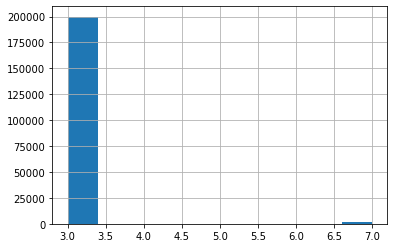

In [47]:
for_predict_df_prod['catBoost'].hist()

In [ ]:
p(for_predict_df_prod['catBoost'], for_predict_df_prod['KNeighborsClassifier_1KN'])

In [44]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            #name_feature != 'BK' and
             #name_feature != 'GR' and
             #name_feature != 'LIT' and
             #name_feature != 'NKTB' and
            #name_feature != 'SP' and
            name_feature != 'catBoost' and 
            name_feature != 'random' and 
            name_feature != 'KNeighborsClassifier_1KN' and 
            name_feature != 'catBoost_prod_26' and 
            name_feature != 'catBoost_prod_1200' and
            name_feature != 'catBoost_prod_100'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('predict_7_facies_correct_26_KN1.csv', index=False)
    
save(for_predict_df_prod)

AGR
ANK
ASP
BK
BK_last_12.0
BK_last_15.0
BK_last_3.0
BK_last_6.0
BK_last_9.0
BK_next_12.0
BK_next_15.0
BK_next_3.0
BK_next_6.0
BK_next_9.0
GR
GR_last_12.0
GR_last_15.0
GR_last_3.0
GR_last_6.0
GR_last_9.0
GR_next_12.0
GR_next_15.0
GR_next_3.0
GR_next_6.0
GR_next_9.0
LIT
NKTB
NKTB_last_12.0
NKTB_last_15.0
NKTB_last_3.0
NKTB_last_6.0
NKTB_last_9.0
NKTB_next_12.0
NKTB_next_15.0
NKTB_next_3.0
NKTB_next_6.0
NKTB_next_9.0
SP
interval_lenght_GRinterval_0.15_
interval_lenght_GRinterval_0.2_
max_GRinterval_0.15_GR
max_GRinterval_0.2_GR
min_GRinterval_0.15_GR
min_GRinterval_0.2_GR
